In [2]:
import xarray as xr
import rioxarray # for the .rio functions
import matplotlib.pyplot as plt
import numpy as np

from pyproj import Transformer
from scipy.interpolate import griddata

In [3]:
ds = xr.open_dataset('RACMO.nc')
ds

<xarray.Dataset> Size: 625MB
Dimensions:       (rlat: 650, rlon: 646, height: 1, nblock1: 40, nblock2: 400,
                   time: 366, bnds: 2)
Coordinates:
    lon           (rlat, rlon) float64 3MB ...
    lat           (rlat, rlon) float64 3MB ...
  * rlon          (rlon) float64 5kB -33.4 -33.3 -33.2 -33.1 ... 30.9 31.0 31.1
  * rlat          (rlat) float64 5kB -27.5 -27.4 -27.3 -27.2 ... 37.2 37.3 37.4
  * height        (height) float64 8B 0.0
  * time          (time) datetime64[ns] 3kB 1980-01-01 1980-01-02 ... 1980-12-31
Dimensions without coordinates: nblock1, nblock2, bnds
Data variables:
    dir           (rlat, rlon) float64 3MB ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    time_bnds     (time, bnds) datetime64[ns] 6kB ...
    dtg           (time) int32 1kB ...
    date_bnds     (time, bnds) int32 3kB ...
    hms_bnds      (time, bnds) int32 3kB ...
    assigned      (time) int32 1kB ...
    rotated_pole  float32 4B ...
    pr            (time, height, rlat, rlon) float32 615MB ...
Attributes:
    Conventions:   CF-1.4
    source:        RACMO2
    Domain:        PXARC11
    Experiment:    RACMO2.4.1_historical
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    CreationDate:  Tue Nov 21 10:49:44 2023
    comment:       asim2cdf: cpar=pr, iwmo=127, ilvt=105, ilev=0, idh=24, iha...
    title:         Precipitation

In [4]:
ds['pr'] = ds['pr'] *31536000

In [5]:
print(ds.rio.crs)

None


Text(0.5, 1.0, 'Longitude')

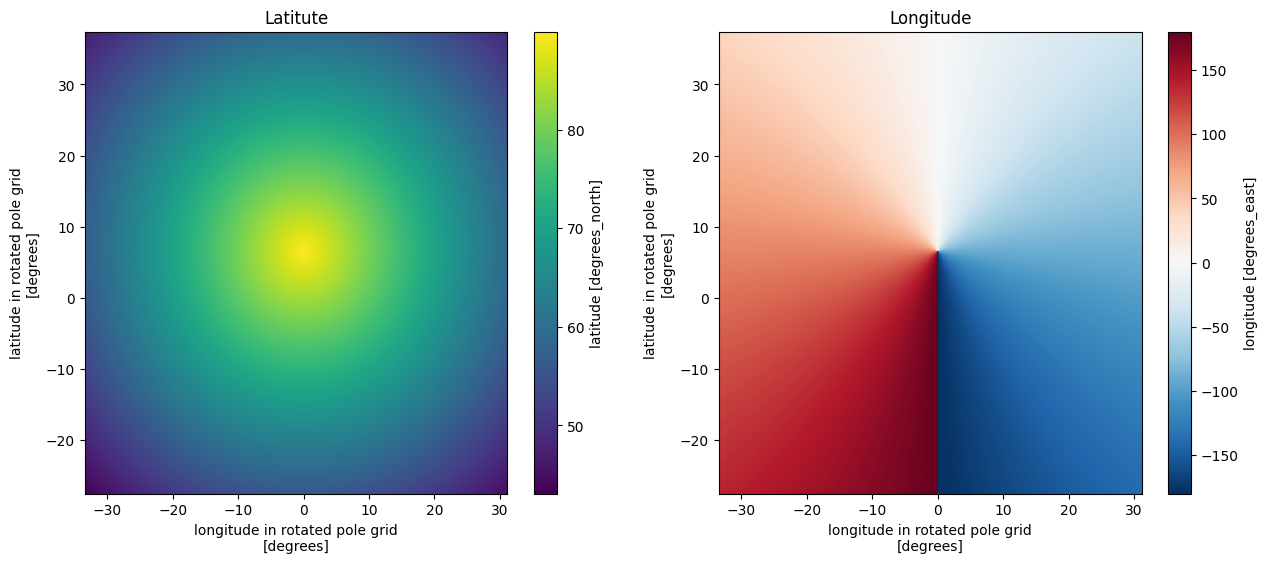

In [6]:
fig,axs = plt.subplots(ncols=2, figsize=(15,6))
ds.lat.plot(ax=axs[0])
ds.lon.plot(ax=axs[1])
axs[0].set_title("Latitute")
axs[1].set_title("Longitude")

In [7]:
EPSG_dist = 3572
EPSG_N_P_STEREOGRAPHIC = 3995

In [8]:
transformer = Transformer.from_crs(4326, EPSG_dist, always_xy=True)
transformer

<Concatenated Operation Transformer: pipeline>
Description: axis order change (2D) + North Pole Lambert Azimuthal Equal Area (Alaska)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)

In [9]:
x_reprojected, y_reprojected = transformer.transform(ds.lon, ds.lat)
x_reprojected.shape
y_reprojected.shape


(650, 646)

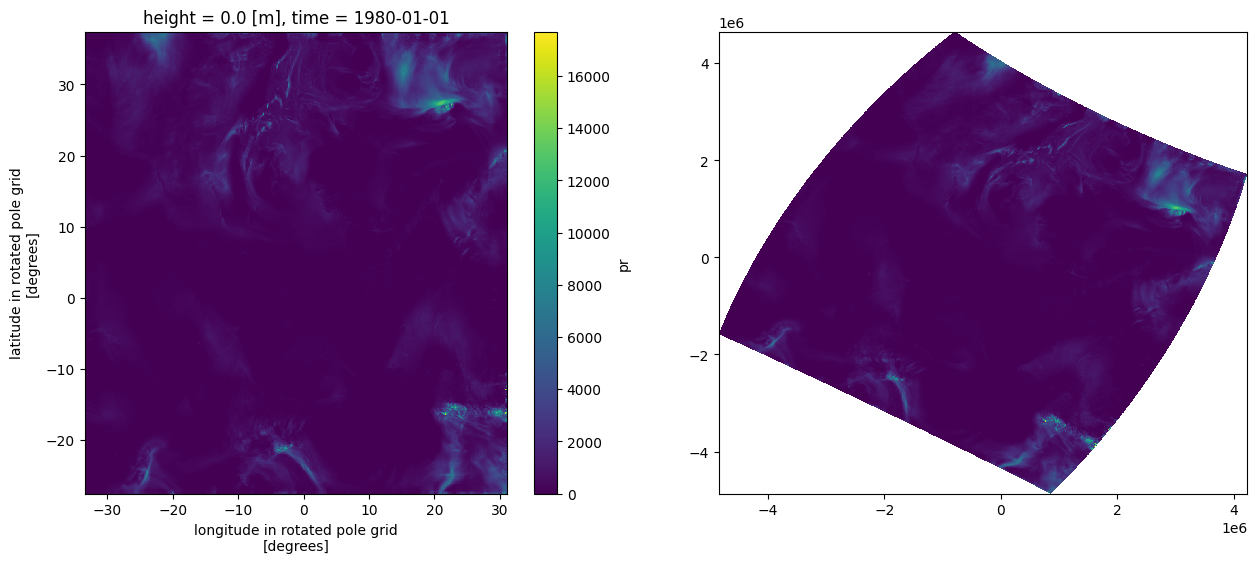

In [10]:

fig,axs = plt.subplots(ncols=2, figsize=(15, 6))
ds['pr'].isel(time = 0).isel(height = 0).plot(ax=axs[0])
axs[1].pcolormesh(x_reprojected, y_reprojected, ds['pr'].isel(height = 0).isel(time = 0))

In [11]:
aspect = ds.rlat.size / ds.rlon.size
nx = 200
ny = int(nx * aspect)
shape = (1, ny, nx)
print(shape)

(1, 201, 200)


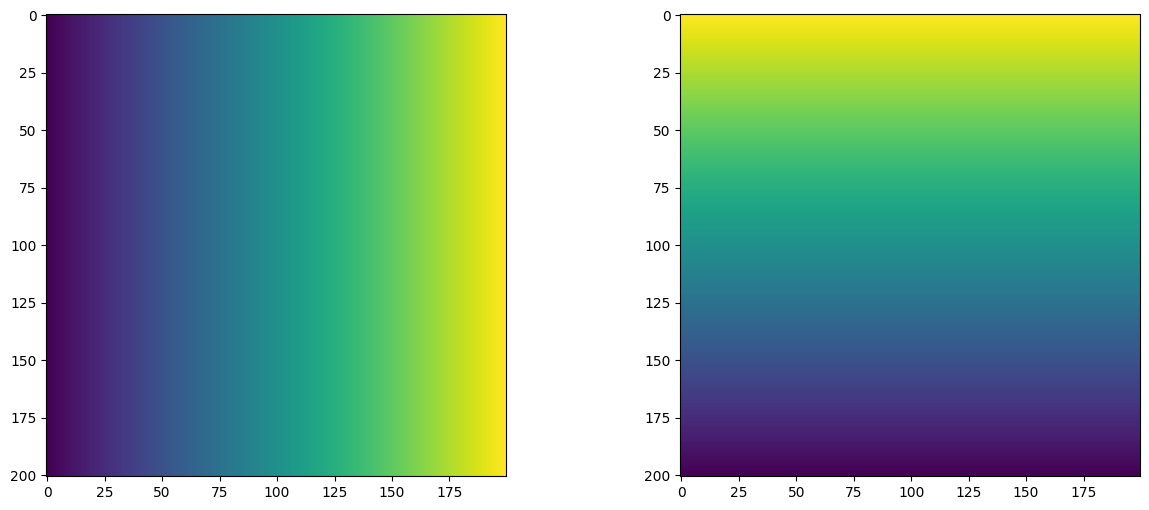

In [12]:
x_target = np.linspace(x_reprojected.min(), x_reprojected.max(), nx)
y_target = np.linspace(y_reprojected.min(), y_reprojected.max(), ny)[::-1]
X_target, Y_target = np.meshgrid(x_target, y_target)
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
axs[0].imshow(X_target)
axs[1].imshow(Y_target)


In [13]:
regridded_data = griddata(
list(zip(x_reprojected.ravel(), y_reprojected.ravel())),
ds['pr'].isel(height = 0).isel(time = 0).to_numpy().ravel(),
list(zip(X_target.ravel(), Y_target.ravel())),
method='linear',

)


In [14]:
regridded_data.shape

(40200,)

In [15]:
regridded_data = regridded_data.reshape(shape)
regridded_data.shape

(1, 201, 200)

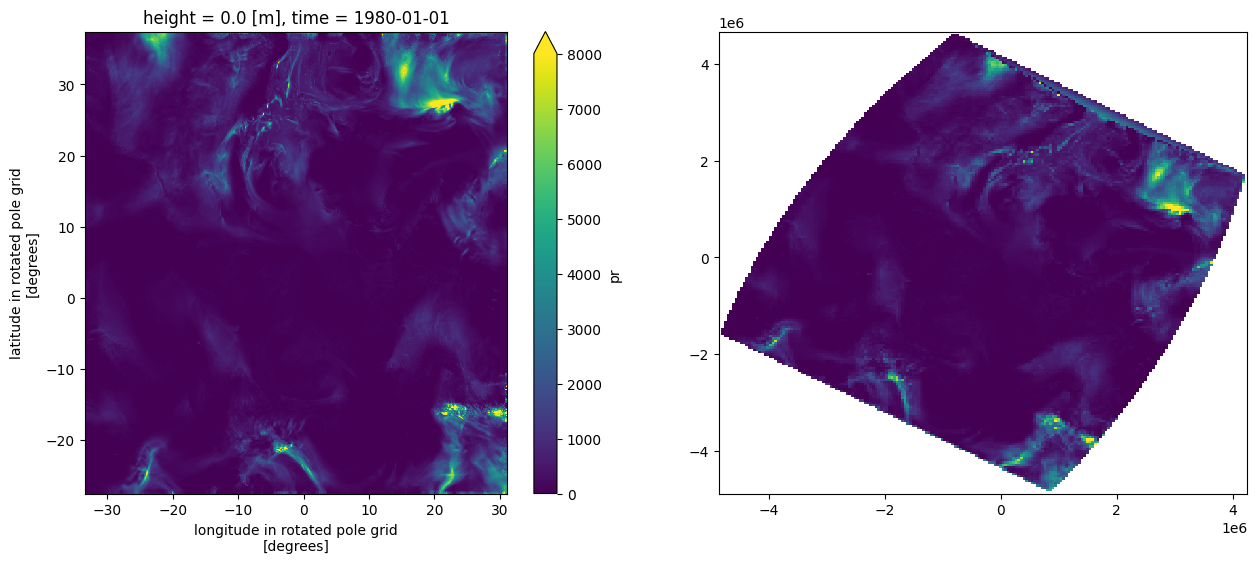

In [16]:
fig,axs = plt.subplots(ncols=2, figsize=(15, 6))
ds['pr'].isel(time = 0).isel(height = 0).plot(ax=axs[0], vmin = 0, vmax = 8000)
axs[1].pcolormesh(X_target, Y_target, regridded_data[0], vmin = 0, vmax = 8000)

In [17]:
xrdata = xr.DataArray(
    regridded_data, 
    dims = ['time', 'y', 'x'],
    coords = (ds.time[:1], y_target, x_target)
    ).rio.write_crs(EPSG_dist)
xrdata
print(xrdata.rio.crs)


EPSG:3572


______
now importing another dataset HCLIM to compare

In [18]:
ds2 = xr.open_dataset("hclim.nc")
ds2

<xarray.Dataset> Size: 9MB
Dimensions:              (time: 1, bnds: 2, y: 709, x: 629)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2010-07-01T06:00:00
    lon                  (y, x) float64 4MB ...
    lat                  (y, x) float64 4MB ...
  * x                    (x) float64 5kB 0.0 1.1e+04 ... 6.897e+06 6.908e+06
  * y                    (y) float64 6kB 0.0 1.1e+04 ... 7.777e+06 7.788e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds            (time, bnds) datetime64[ns] 16B ...
    Polar_Stereographic  |S1 1B ...
    pr                   (time, y, x) float32 2MB ...
Attributes: (12/14)
    CDI:               Climate Data Interface version 1.9.9rc1 (https://mpime...
    Conventions:       CF-1.4
    history:           Mon Jun 17 21:08:52 2024: cdo ensmean pr_2010_mm.nc pr...
    institute_id:      HCLIMcom
    model_id:          HCLIM43_Arctic
    experiment_id:     ARC11_ALADIN43_v1_ERA5_r1i1p1f1_eval
    ...                ...
    driving_model_id:  ERA5
    creation_date:     Fri Mar  8 14:58:01 2024
    title:             Precipitation
    comment:           Created with gl/xtool
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.9rc1 (https://mpime...

In [19]:
print(ds2.rio.crs)

None


Text(0.5, 1.0, 'Longitude')

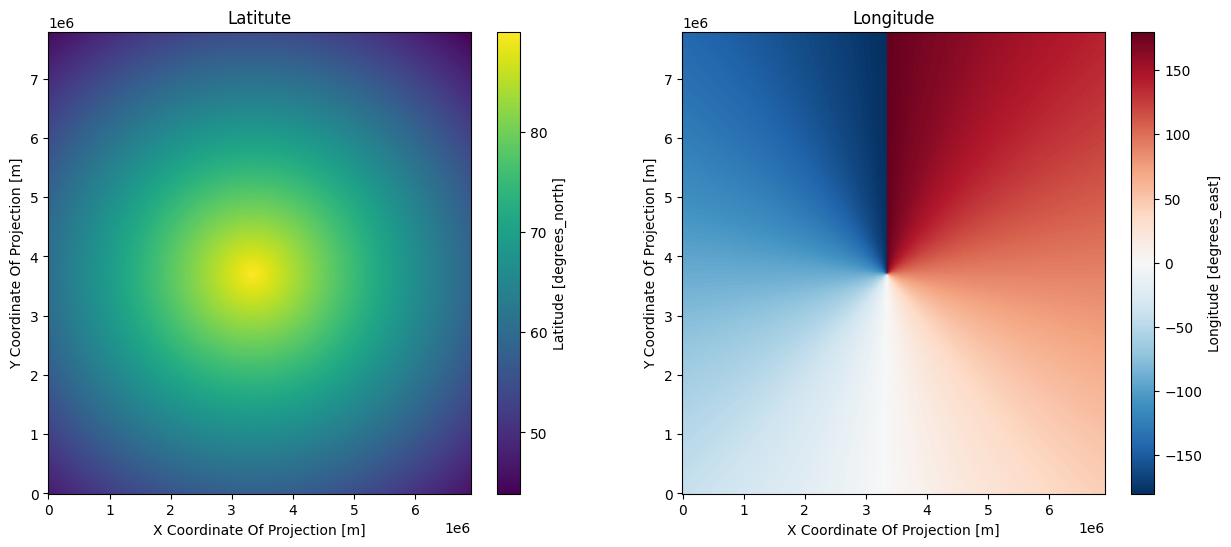

In [20]:
fig,axs = plt.subplots(ncols=2, figsize=(15,6))
ds2.lat.plot(ax=axs[0])
ds2.lon.plot(ax=axs[1])
axs[0].set_title("Latitute")
axs[1].set_title("Longitude")

In [21]:
x_reprojected2, y_reprojected2 = transformer.transform(ds2.lon, ds2.lat)
x_reprojected2.shape
y_reprojected2.shape


(709, 629)

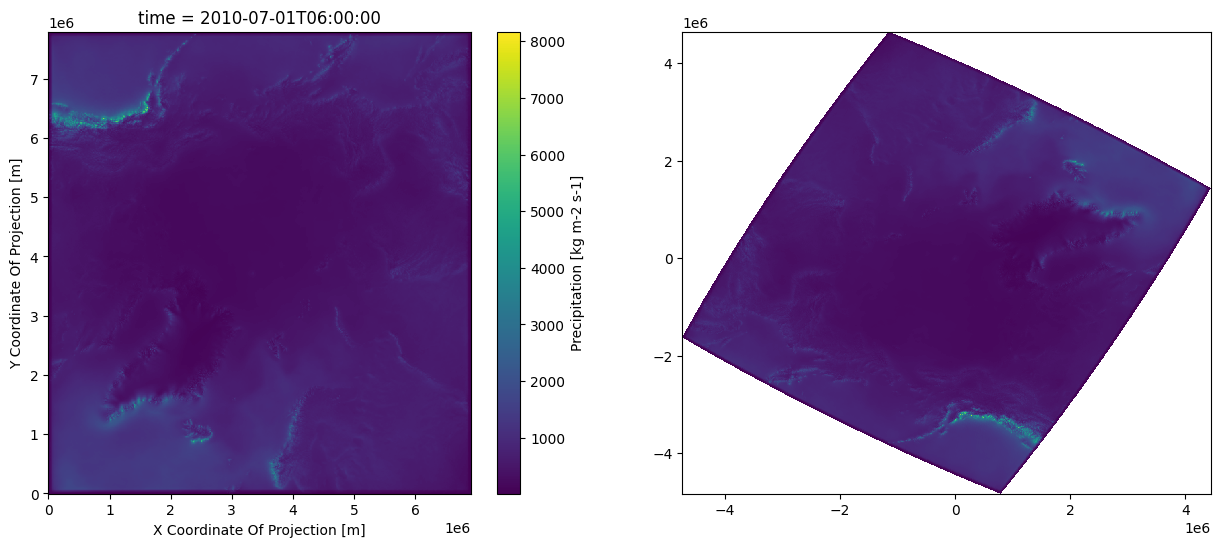

In [22]:

fig,axs = plt.subplots(ncols=2, figsize=(15, 6))
ds2['pr'].isel(time = 0).plot(ax=axs[0])
axs[1].pcolormesh(x_reprojected2, y_reprojected2, ds2['pr'].isel(time = 0))

In [23]:
regridded_data2 = griddata(
list(zip(x_reprojected2.ravel(), y_reprojected2.ravel())),
ds2['pr'].isel(time = 0).to_numpy().ravel(),
list(zip(X_target.ravel(), Y_target.ravel())),
method='linear',

)
regridded_data2 = regridded_data2.reshape(shape)
regridded_data2.shape

(1, 201, 200)

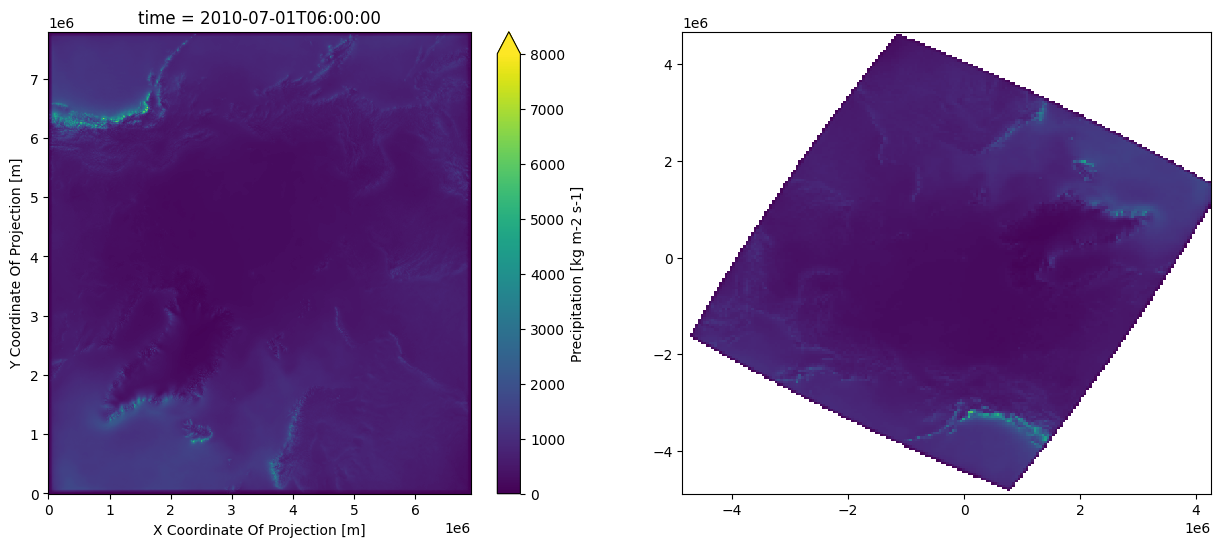

In [24]:
fig,axs = plt.subplots(ncols=2, figsize=(15, 6))
ds2['pr'].isel(time = 0).plot(ax=axs[0], vmin = 0, vmax =8000)
axs[1].pcolormesh(X_target, Y_target, regridded_data2[0], vmin = 0, vmax = 8000)

___
now comparing

5963.951231715456
-10748.878238024126


(None, None)

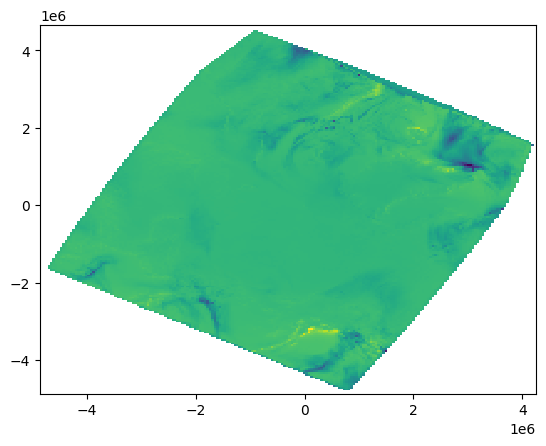

In [25]:
A = regridded_data2[0]-regridded_data[0]
plt.pcolormesh(X_target, Y_target, A)
print(np.nanmax(A)), print(np.nanmin(A))


In [26]:
## import cartopy for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature


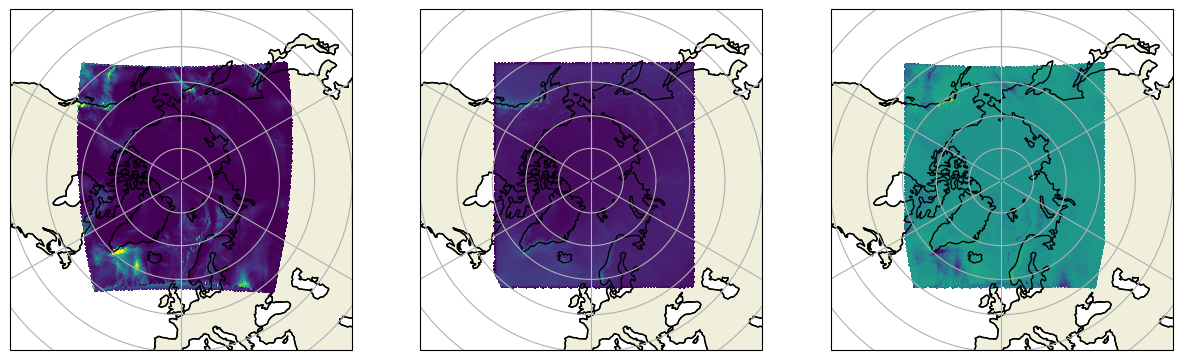

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axs[0].set_extent([-180, 180, 40, 90], ccrs.PlateCarree())
axs[1].set_extent([-180, 180, 40, 90], ccrs.PlateCarree())
axs[2].set_extent([-180, 180, 40, 90], ccrs.PlateCarree())

# Add coastlines and land features
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.gridlines()

# Plot data with the correct projection
axs[0].pcolormesh(X_target, Y_target, regridded_data[0], transform=ccrs.epsg(3572), vmin=0, vmax=8000)
axs[1].pcolormesh(X_target, Y_target, regridded_data2[0], transform=ccrs.epsg(3572), vmin=0, vmax=8000)
axs[2].pcolormesh(X_target, Y_target, A, transform=ccrs.epsg(3572), vmin=-8000, vmax=8000)



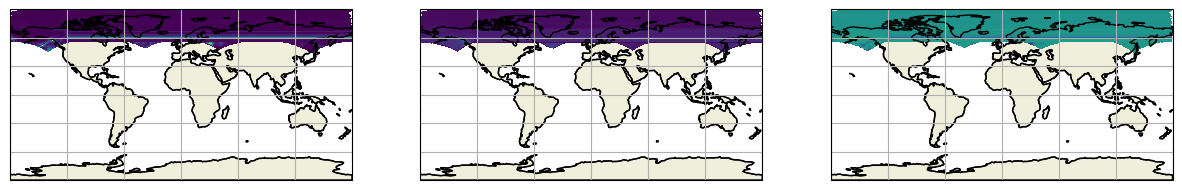

In [28]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
axs[0].set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
axs[2].set_extent([-180, 180, -90, 90], ccrs.PlateCarree())

# Add coastlines and land features
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.gridlines()

# Plot data with the correct projection
axs[0].pcolormesh(X_target, Y_target, regridded_data[0], transform=ccrs.epsg(3572), vmin=0, vmax=8000)
axs[1].pcolormesh(X_target, Y_target, regridded_data2[0], transform=ccrs.epsg(3572), vmin=0, vmax=8000)
axs[2].pcolormesh(X_target, Y_target, A, transform=ccrs.epsg(3572), vmin=-8000, vmax=8000)